In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

## Modeling for Machine Learning

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [233]:
import warnings

warnings.filterwarnings('ignore')

## Read csv files

In [234]:
train = pd.read_csv('train.csv')
gender = pd.read_csv('gender_submission.csv')
test = pd.read_csv('test.csv')

In [235]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
497,498,0,3,"Shellard, Mr. Frederick William",male,NaN,0,0,C.A. 6212,15.1000,NaN,S
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S
189,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S
617,618,0,3,"Lobb, Mrs. William Arthur (Cordelia K Stanlick)",female,26.0,1,0,A/5. 3336,16.1000,NaN,S
575,576,0,3,"Patchett, Mr. George",male,19.0,0,0,358585,14.5000,NaN,S


## Insert column to test file from gender file

In [236]:
test.insert(1, 'Survived', gender['Survived'], True)

## Concatenate test and train

In [237]:
frames = [train, test]
train = pd.concat(frames, ignore_index=True)

## Feature engineering

<p>Many algorithms in machine learning require a numerical representation of
objects, since such representations facilitate processing and statistical
analysis. This is where the feature engineering come into play.
The goal is to turn data into information, and information into insight.</p>

## Title

In [238]:
train["Title"] = train["Name"].str.extract('([A-Za-z]+)\.', expand=False)

train["Title"].value_counts()

titre = {"Mr": 0, "Miss": 1, "Mrs": 2,
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
train['Title'] = train['Title'].map(titre)

## Ticket

In [239]:
train['Family_Name'] = train['Name'].str.split(',')

for f in range(len(train)):
    train.loc[f, 'Family_Name'] = train.loc[f, 'Family_Name'][0]

In [240]:
for i1 in range(len(train)):
    for i2 in range(i1+1,len(train)):
        if train.loc[i1, 'Family_Name'] == train.loc[i2, 'Family_Name'] and train.loc[i1, 'Ticket'] == train.loc[i2, 'Ticket']:
            train.loc[i1, 'Ticket'] =1
            train.loc[i2, 'Ticket'] = 1

In [241]:
for i1 in range(len(train)):
    for i3 in range(i1+1,len(train)):
        if train.loc[i1, 'Family_Name'] == train.loc[i3, 'Family_Name'] and train.loc[i1, 'Ticket'] != train.loc[i3, 'Ticket']:
            train.loc[i1, 'Ticket'] =2
            train.loc[i3, 'Ticket'] = 2

In [242]:
for i4 in range(len(train)):
   if len(str(train.loc[i4, 'Ticket'])) > 1:
       train.loc[i4, 'Ticket'] = 3

## Sex

- male: 0
- female: 1

In [243]:
sex_mapping = {"male": 0, "female": 1}

train['Sex'] = train['Sex'].map(sex_mapping)

## Age

In [244]:
train["Age"].fillna(train.groupby("Pclass")["Age"].transform("median"),inplace=True)

for a in range(len(train)):
    if train.loc[a, 'Age'] <=20:
        train.loc[a, 'Age'] = 0
    elif 20 < train.loc[a, 'Age'] <= 40:
        train.loc[a, 'Age'] = 1
    elif 40 < train.loc[a, 'Age'] <= 60:
        train.loc[a, 'Age'] = 2
    elif train.loc[a, 'Age'] > 60:
        train.loc[a, 'Age'] = 3

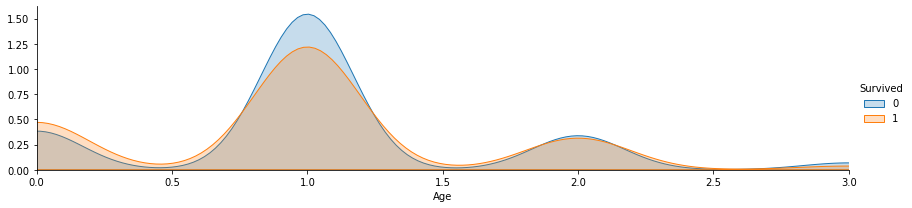

In [245]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()


## Embarked

In [246]:
train['Embarked'] = train['Embarked'].fillna('S')

embarked_mapping = {"S": 0, "C": 1, "Q": 2}

train['Embarked'] = train['Embarked'].map(embarked_mapping)

## Fare

In [247]:
# fill missing Fare with median fare for each Pclass
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)

for f in range(len(train)):
    if train.loc[f, 'Fare'] <=17:
        train.loc[f, 'Fare'] = 0
    elif 17 < train.loc[f, 'Fare'] <=100:
        train.loc[f, 'Fare'] = 1
    elif train.loc[f, 'Fare'] > 100:
        train.loc[f, 'Fare'] = 2

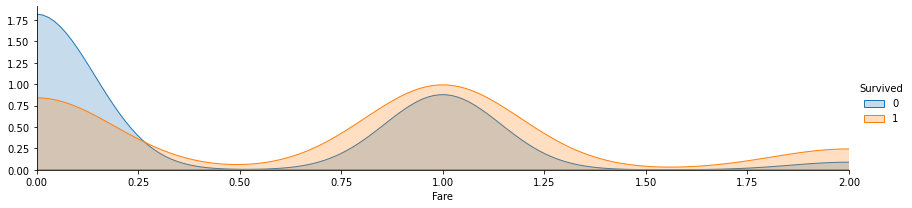

In [248]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.show()


## Cabin

In [249]:
train.Cabin.value_counts()
train['Cabin'] = train['Cabin'].str[:1]

cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}

train['Cabin'] = train['Cabin'].map(cabin_mapping)

# fill missing Fare with median fare for each Pclass
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

# Family size

In [250]:
train["FamilySize"] = train["SibSp"] + train["Parch"] +1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
train['FamilySize'] = train['FamilySize'].map(family_mapping)

In [251]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Name,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,2,0.0,2.0,0,0,Braund,0.4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1.0,1,0,1,1.0,0.8,1,2,Cumings,0.4
2,3,1,3,"Heikkinen, Miss. Laina",1,1.0,0,0,3,0.0,2.0,0,1,Heikkinen,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1.0,1,0,1,1.0,0.8,0,2,Futrelle,0.4
4,5,0,3,"Allen, Mr. William Henry",0,1.0,0,0,2,0.0,2.0,0,0,Allen,0.0


## Drop columns

In [252]:
features_drop = ['PassengerId', 'Name', 'Family_Name', 'FamilySize']
titanic = train.drop(features_drop, axis=1)

In [253]:
titanic.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,0,1.0,1,0,2,0.0,2.0,0,0
1,1,1,1,1.0,1,0,1,1.0,0.8,1,2
2,1,3,1,1.0,0,0,3,0.0,2.0,0,1
3,1,1,1,1.0,1,0,1,1.0,0.8,0,2
4,0,3,0,1.0,0,0,2,0.0,2.0,0,0


## Dataframe split

In [254]:
# Feature X et Target y
X = titanic.drop(columns=['Survived'],axis=1)
y = titanic['Survived']

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Confusion Matrix

Accuracy = 0.84
Recall = 0.78



<AxesSubplot:title={'center':'Confusion Matrix '}>

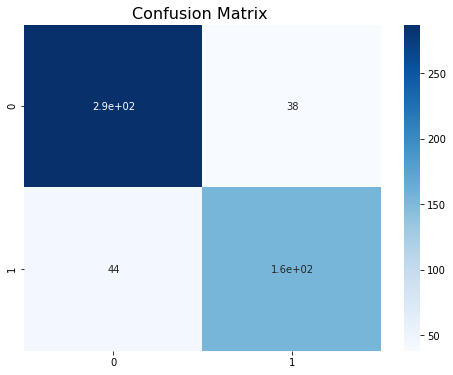

In [256]:
model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix ', size=16)
sns.heatmap(cm, annot=True, cmap='Blues')

## Cross Validation (K-fold)

In [257]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## KNN Modeling

In [258]:
def KNN_model(k, p):
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p)
    scoring = 'accuracy'
    score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
    return score

In [259]:
# kNN Score
def plot_KNN_model():
    p = [1,2]
    for val in p:
        ix= []
        KNN_Score = []
        for k in np.arange(2, 32, 3):
            print(f' pour k = {k} et p = {val}, KNN Score = {round(np.mean(KNN_model(k, val))*100, 2)}')
            ix.append(k)
            KNN_Score.append(round(np.mean(KNN_model(k, val))*100, 2))
        if val ==1:
            plt.plot(ix, KNN_Score, color='red', label='Manhattan distance')
        else:
            plt.plot(ix, KNN_Score, color='blue', label=' Euclidean distance')
        print('******************************')
        plt.legend(loc='best')
        plt.xlabel('K')
        plt.ylabel('KNN SCORE')

 pour k = 2 et p = 1, KNN Score = 79.99
 pour k = 5 et p = 1, KNN Score = 85.47
 pour k = 8 et p = 1, KNN Score = 85.59
 pour k = 11 et p = 1, KNN Score = 87.13
 pour k = 14 et p = 1, KNN Score = 86.87
 pour k = 17 et p = 1, KNN Score = 87.13
 pour k = 20 et p = 1, KNN Score = 86.87
 pour k = 23 et p = 1, KNN Score = 86.87
 pour k = 26 et p = 1, KNN Score = 87.0
 pour k = 29 et p = 1, KNN Score = 87.38
******************************
 pour k = 2 et p = 2, KNN Score = 79.99
 pour k = 5 et p = 2, KNN Score = 85.22
 pour k = 8 et p = 2, KNN Score = 84.96
 pour k = 11 et p = 2, KNN Score = 86.11
 pour k = 14 et p = 2, KNN Score = 86.36
 pour k = 17 et p = 2, KNN Score = 86.24
 pour k = 20 et p = 2, KNN Score = 86.24
 pour k = 23 et p = 2, KNN Score = 86.24
 pour k = 26 et p = 2, KNN Score = 86.24
 pour k = 29 et p = 2, KNN Score = 86.24
******************************


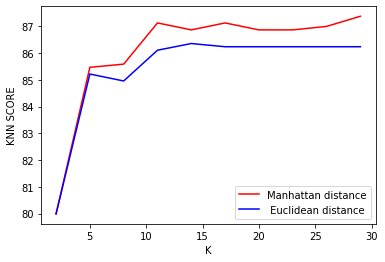

In [260]:
plot_KNN_model()

## Decision Tree

In [261]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.84810127 0.79746835 0.83544304 0.86075949 0.87341772 0.78205128
 0.88461538 0.83333333 0.78205128 0.80769231]


In [262]:
# decision tree Score
round(np.mean(score)*100, 2)

83.05

## Ramdom Forest

In [263]:
rf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(rf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.86075949 0.81012658 0.88607595 0.87341772 0.88607595 0.80769231
 0.88461538 0.80769231 0.84615385 0.83333333]


In [264]:
# Random Forest Score
round(np.mean(score)*100, 2)


84.96

## SVM

In [265]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.89873418 0.83544304 0.88607595 0.89873418 0.88607595 0.88461538
 0.84615385 0.83333333 0.85897436 0.84615385]


In [266]:
# SVM Score
round(np.mean(score)*100,2)

86.74

## Naive Bayes

In [267]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.84810127 0.82278481 0.87341772 0.88607595 0.83544304 0.85897436
 0.87179487 0.82051282 0.82051282 0.79487179]


In [268]:
# Naive Bayes Score
round(np.mean(score)*100, 2)


84.32